# 기업 연계 프로젝트(리코맨즈) 4조

In [1]:
import pandas as pd
import re
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install transformers torch
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from wordcloud import WordCloud
from collections import Counter
import math
from scipy.interpolate import make_interp_spline

## 0. 데이터 전처리

In [2]:
# order & review 취합
renewal_order1 = pd.read_csv('renewal_order1.csv')
renewal_order2 = pd.read_csv('renewal_order2.csv')
renewal_order3 = pd.read_csv('renewal_order3.csv')
renewal_order4 = pd.read_csv('renewal_order4.csv')
review_230501_231101 = pd.read_csv('230501_231101_review.csv')
review_231101_240430 = pd.read_csv('231101_240430_review.csv')
review_240501_241031 = pd.read_csv('240501_241031_review.csv')
review_241101_250320 = pd.read_csv('241101_250320_review.csv')

# 주문 데이터 통합
order_all = pd.concat([
    renewal_order1,
    renewal_order2,
    renewal_order3,
    renewal_order4
], ignore_index=True)

# 리뷰 데이터 통합
review_all = pd.concat([
    review_230501_231101,
    review_231101_240430,
    review_240501_241031,
    review_241101_250320
], ignore_index=True)

# 통합 order 데이터 저장
order_all.to_csv('order_all.csv', index=False, encoding='utf-8-sig')

# 통합 review 데이터 저장
review_all.to_csv('review_all.csv', index=False, encoding='utf-8-sig')

In [3]:
# member 전처리 
member_info = pd.read_csv('member_info.csv')

# 전화번호 끝자리만 남기기
member_info['휴대폰번호'] = member_info['휴대폰번호'].astype(str).str[-4:]

# 주문시간 삭제
member_info['최종접속일'] = pd.to_datetime(member_info['최종접속일']).dt.date
member_info['최종주문일'] = pd.to_datetime(member_info['최종주문일']).dt.date

# 금액 정수로 변경
cols_to_convert = ['총구매금액']
member_info[cols_to_convert] = member_info[cols_to_convert].astype("Int64")

# 멤버, 제품 컬럼삭제 코드 (아직 진열상태/판매상태 컬럼은 미반영)
member_info = member_info.sort_values(by='회원 가입일')
member_info = member_info.drop(columns=['회원 가입경로', '주소1', '총적립금', '사용가능 적립금', '총 사용 적립금', '누적주문건수', '실결제금액'])

member_info.to_csv('member_cleaned.csv', index=False, encoding='utf-8-sig')

In [4]:
# product 전처리 
product_info = pd.read_csv('제품목록_20250415(미판매포함).csv', encoding='cp949') 

product_info = product_info[(product_info['진열상태'] != 'N') & (product_info['판매상태'] != 'N')]   #39개 제품 제외 (158개->119개)

# 번호 → 카테고리명 매핑 딕셔너리
category_map = {
    '42': 'ALL',
    '148': 'BEST',
    '174': '커플 세트',
    '149': '원석 팔찌',
    '178': '원석 반지',
    '154': '원석 목걸이',
    '160': '원석 키링',
    '155': '헬스',  
}

# 카테고리명을 변환해주는 함수
def replace_category_codes(codes):
    return '|'.join([category_map.get(code, code) for code in codes.split('|')])

product_info['상품분류명'] = product_info['상품분류 번호'].apply(replace_category_codes)
product_info = product_info.drop(columns=['옵션사용', '옵션입력', '진열상태', '판매상태', '상품번호', '상품등록일', '상품분류 번호'])

product_info.to_csv('product_cleaned.csv', index=False, encoding='utf-8-sig')

In [5]:
# order 전처리 
order_all = pd.read_csv("order_all.csv", dtype={"주문자우편번호": str})  # 21392건

# 이상치 1건만 제거
order_all = order_all.loc[order_all['주문자ID'] != '3934758155@k'].copy() # 21391건

# NaN 값을 '비회원'으로 대체
order_all['주문자ID'] = order_all['주문자ID'].fillna('-')
order_all['주문 시 회원등급'] = order_all['주문 시 회원등급'].fillna('비회원')

# 주문시간 삭제
order_all['주문일시'] = pd.to_datetime(order_all['주문일시']).dt.date

# 금액 정수로 변경
cols_to_convert = ['총 주문금액', '총 결제금액', '총 실결제금액(최초정보) (KRW)', '상품구매금액']
order_all[cols_to_convert] = order_all[cols_to_convert].astype("Int64")

# 전화번호 끝자리만 남기기
order_all['주문자 전화번호'] = order_all['주문자 전화번호'].astype(str).str[-4:]

# 고객식별자 생성 (주문자명 + 주문자 전화번호)
order_all['고객식별자'] = order_all['주문자명'].astype(str) + "_" + order_all['주문자 전화번호'].astype(str)

# '회원여부' 컬럼 생성 (회원등급 기준)
회원등급_리스트 = ['GOLD', 'SILVER', '일반회원']
order_all['회원여부'] = order_all['주문 시 회원등급'].apply(lambda x: '회원' if x in 회원등급_리스트 else '비회원')

# '실제회원여부' 컬럼 생성 (member_info의 아이디와 주문자ID 비교)
order_all['실제회원여부'] = order_all['주문자ID'].apply(
    lambda x: '회원' if x in member_info['아이디'].values else '비회원'
)

# 삭제할 컬럼 지정
columns_to_drop = [
    '실제 환불금액', 
    '총 실제 환불금액',
    '환불접수일',
    '상품옵션',
    '주문상품명(옵션포함)',
    '품목별 주문번호',
    '주문상품명(기본)',
    '수량',
    '주문자 가입일',
    '주문자 주소',
    '주문자우편번호',
    '상품 쿠폰 할인금액',
    '주문서 쿠폰 할인금액',
    '결제수단',
    '결제업체',
    '수령인 전화번호',
    '반품접수 구분',
    '결제일시(입금확인일)',
    '결제정보',
    '결제안내',
    '총 배송비(KRW)\xa0(전체 품목에 표시)' # 특수문자 주의
]

# 컬럼 삭제
order_all = order_all.drop(columns=columns_to_drop)
order_all.head()

order_all.to_csv('order_cleaned.csv', index=False, encoding='utf-8-sig')

In [6]:
# review 전처리
review_all = pd.read_csv('review_all.csv')

# 주문시간 삭제
review_all['리뷰작성일시'] = pd.to_datetime(review_all['리뷰작성일시']).dt.date

# 리뷰내용 컬럼에서 해당 패턴 제거
review_all['리뷰내용'] = review_all['리뷰내용'].str.replace(
    r"\(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2} 에 등록된 네이버 페이 구매평\)",
    "",
    regex=True
)

# 필요한 컬럼만 추출
keep_cols = ['리뷰번호', '리뷰작성일시', '작성자ID', '주문번호', '리뷰평점', '상품명', '리뷰내용']
review_types = ['빠른리뷰', '텍스트리뷰', '포토리뷰', '동영상리뷰', '설문리뷰', 'SNS리뷰']

# 리뷰 유형을 문자열로 합치기
def merge_review_types(row):
    types = []
    for col in review_types:
        if row.get(col) == True or row.get(col) == 1:  # 1 또는 True이면 해당 리뷰 유형 포함
            types.append(col)
    return ', '.join(types) if types else '일반'

review_all['리뷰유형'] = review_all.apply(merge_review_types, axis=1)

# 최종 컬럼 정리
final_cols = keep_cols + ['리뷰유형']
review_cleaned = review_all[final_cols]
review_cleaned

review_cleaned.to_csv('review_cleaned.csv', index=False, encoding='utf-8-sig')

In [7]:
member = pd.read_csv('member_cleaned.csv')
product = pd.read_csv('product_cleaned.csv')
order = pd.read_csv('order_cleaned.csv')
review = pd.read_csv('review_cleaned.csv')
post = pd.read_csv('post_all.csv', encoding='cp949')
meta_ad = pd.read_csv('meta_ad_final3.csv', encoding='cp949')

## 1. 회원 vs 비회원 구매 패턴 분석

### 1) 재구매율

In [8]:
# 필요한 컬럼만 추출 (주문일시 추가)
order_sub = order[['주문자ID', '고객식별자', '실제회원여부', '주문일시']].copy()

# 주문일시를 datetime 타입으로 변환
order_sub['주문일시'] = pd.to_datetime(order['주문일시'])

# 기간 설정 
start_date = '2023-04-01'
end_date = '2025-03-31'

# 설정한 기간에 해당하는 데이터만 필터링
order_sub = order_sub[(order_sub['주문일시'] >= start_date) & (order_sub['주문일시'] <= end_date)]

# 회원과 비회원 나누기
회원 = order_sub[order_sub['실제회원여부'] == '회원']
비회원 = order_sub[order_sub['실제회원여부'] == '비회원']

# 각각 주문 횟수 집계
회원_order_counts = 회원['주문자ID'].value_counts()
비회원_order_counts = 비회원['고객식별자'].value_counts()

# '재구매여부' 초기화
order_sub['재구매여부'] = '1회구매'

# 회원 중 재구매자 표시
order_sub.loc[
    (order_sub['실제회원여부'] == '회원') &
    (order_sub['주문자ID'].isin(회원_order_counts[회원_order_counts >= 2].index)),
    '재구매여부'
] = '재구매'

# 비회원 중 재구매자 표시
order_sub.loc[
    (order_sub['실제회원여부'] == '비회원') &
    (order_sub['고객식별자'].isin(비회원_order_counts[비회원_order_counts >= 2].index)),
    '재구매여부'
] = '재구매'

# 고유 고객 기준 데이터 만들기
unique_customers = order_sub.drop_duplicates(subset=['주문자ID', '고객식별자'])

# 회원/비회원 고객 수
회원수 = len(unique_customers[unique_customers['실제회원여부'] == '회원'])
비회원수 = len(unique_customers[unique_customers['실제회원여부'] == '비회원'])

# 재구매한 회원/비회원 수
재구매_회원 = len(unique_customers[
    (unique_customers['실제회원여부'] == '회원') &
    (unique_customers['재구매여부'] == '재구매')
])

재구매_비회원 = len(unique_customers[
    (unique_customers['실제회원여부'] == '비회원') &
    (unique_customers['재구매여부'] == '재구매')
])

# 재구매율 계산
재구매율_회원 = (재구매_회원 / 회원수) * 100 if 회원수 else 0
재구매율_비회원 = (재구매_비회원 / 비회원수) * 100 if 비회원수 else 0

# 결과 출력
print("[회원]")
print(f"총 회원 수: {회원수}명")
print(f"재구매 회원 수: {재구매_회원}명")
print(f"재구매율: {재구매율_회원:.2f}%")

print("[비회원]")
print(f"총 비회원 수: {비회원수}명")
print(f"재구매 비회원 수: {재구매_비회원}명")
print(f"재구매율: {재구매율_비회원:.2f}%")

[회원]
총 회원 수: 4093명
재구매 회원 수: 1524명
재구매율: 37.23%
[비회원]
총 비회원 수: 9985명
재구매 비회원 수: 3024명
재구매율: 30.29%


### 2) 월별 매출 및 주문량

=== 수량 ===
회원여부     비회원   회원
년월               
2024-03  561  307
2024-04  476  232
2024-05  383  305
2024-06  308  224
2024-07  321  179
2024-08  382  230
2024-09  526  302
2024-10  455  306
2024-11  417  285
2024-12  527  308
2025-01  581  336
2025-02  444  317

=== 매출 ===
회원여부            비회원          회원
년월                             
2024-03  33197000.0  24003000.0
2024-04  27269000.0  17806000.0
2024-05  23418000.0  27062000.0
2024-06  17821000.0  16168000.0
2024-07  19102000.0  11241000.0
2024-08  22174500.0  16611500.0
2024-09  33239500.0  21367000.0
2024-10  31781000.0  23078500.0
2024-11  23448000.0  21235000.0
2024-12  32081000.0  21996000.0
2025-01  36154500.0  25024000.0
2025-02  25730500.0  23887000.0


C:\Users\user\AppData\Local\Temp\ipykernel_10512\4094226944.py:76: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_10512\4094226944.py:76: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_10512\4094226944.py:76: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_10512\4094226944.py:76: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_10512\4094226944.py:76: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_10512\4094226944.py:76: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from

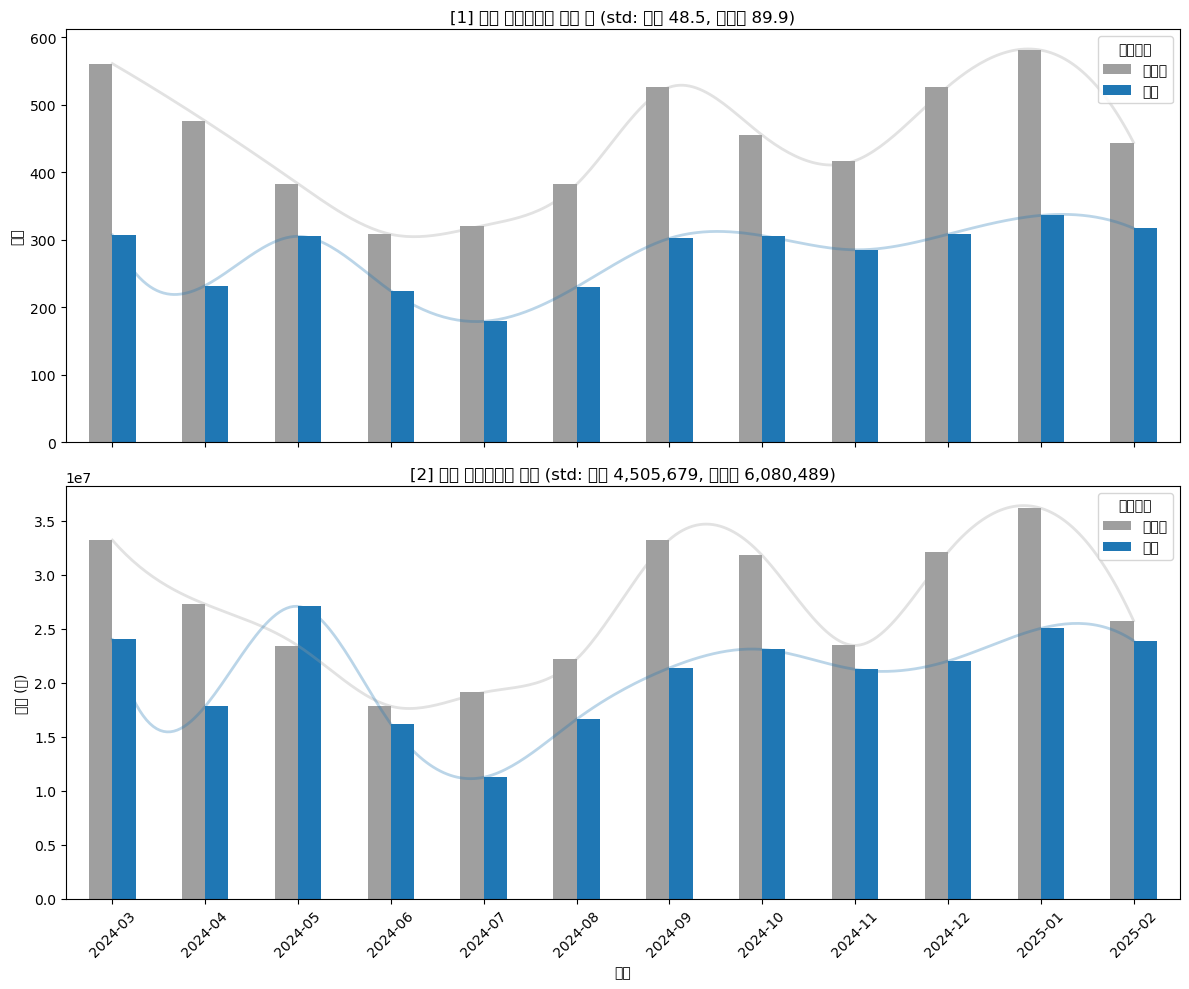

In [9]:
# 주문일자 변환
order['주문일시'] = pd.to_datetime(order['주문일시'])

# 날짜 필터링
start_date = '2024-03-01'
end_date = '2025-02-28'
filtered_order = order[
    (order['주문일시'] >= start_date) & 
    (order['주문일시'] <= end_date)
].copy()

# '년월' 컬럼 생성
filtered_order['년월'] = filtered_order['주문일시'].dt.to_period('M').astype(str)

# 피벗 테이블 생성
qty_pivot = filtered_order.groupby(['년월', '회원여부']).size().unstack(fill_value=0)
sales_pivot = filtered_order.groupby(['년월', '회원여부'])['총 주문금액'].sum().unstack(fill_value=0)

# 출력
print("=== 수량 ===")
print(qty_pivot)
print("\n=== 매출 ===")
print(sales_pivot)


# 표준편차 계산
회원_std = qty_pivot['회원'].std()
비회원_std = qty_pivot['비회원'].std()
회원_매출_std = sales_pivot['회원'].std()
비회원_매출_std = sales_pivot['비회원'].std()

# 색상 설정
colors = {'회원': '#1f77b4', '비회원': '#9f9f9f'}

# 공통 x축 (정수 인덱스) + 라벨
x = np.arange(len(qty_pivot.index))
x_labels = qty_pivot.index
x_smooth = np.linspace(x.min(), x.max(), 300)

# Plot 준비
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

### [1] 수량 그래프 (막대 + 보조선)
qty_pivot.plot(kind='bar', ax=axes[0],
               color=[colors.get(col, '#333333') for col in qty_pivot.columns])

for col in qty_pivot.columns:
    y = qty_pivot[col].values
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)
    axes[0].plot(x_smooth, y_smooth, color=colors.get(col), alpha=0.3, linewidth=2)  # 연한 곡선

axes[0].set_title(f"[1] 월별 회원여부별 주문 수 (std: 회원 {회원_std:.1f}, 비회원 {비회원_std:.1f})")
axes[0].set_ylabel('수량')
axes[0].set_xticks(x)
axes[0].set_xticklabels(x_labels, rotation=45)
axes[0].legend(title='회원여부', loc='upper right')

### [2] 매출 그래프 (막대 + 보조선)
sales_pivot.plot(kind='bar', ax=axes[1],
                 color=[colors.get(col, '#333333') for col in sales_pivot.columns])

for col in sales_pivot.columns:
    y = sales_pivot[col].values
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)
    axes[1].plot(x_smooth, y_smooth, color=colors.get(col), alpha=0.3, linewidth=2)  # 연한 곡선

axes[1].set_title(f"[2] 월별 회원여부별 매출 (std: 회원 {회원_매출_std:,.0f}, 비회원 {비회원_매출_std:,.0f})")
axes[1].set_ylabel('매출 (원)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_labels, rotation=45)
axes[1].legend(title='회원여부', loc='upper right')

# 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()

### 3) LTV

회원 vs 비회원 1인당 총 구매금액 분석


,회원여부,고객수,총합,평균,표준편차,최대값,최소값
0,비회원,9981,857918000,85955,103806,2589000,0
1,회원,4097,473691500,115619,165622,3980000,0


고객구분별 1인당 평균 총 구매금액 (LTV)


,고객구분,1인당 평균 구매금액 (LTV)
0,비회원,85955
1,회원,115619


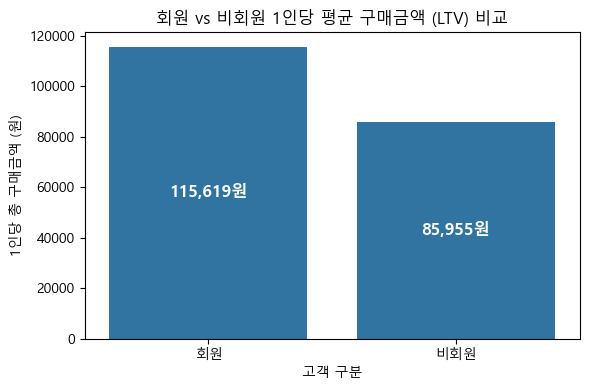

In [10]:
# 분석 함수 정의
def analyze_customer_type(df, label):
    # 고객별 총 주문금액과 주문 건수 집계
    total_by_customer = df.groupby('고객식별자')['총 주문금액'].sum()
    count_by_customer = df.groupby('고객식별자').size()
    
    # 고객 단위 DataFrame 구성
    분석_df = pd.DataFrame({
        '총 주문금액': total_by_customer,
        '주문 횟수': count_by_customer
    })
    분석_df['객단가'] = 분석_df['총 주문금액'] / 분석_df['주문 횟수']
    
    # 지표 계산
    총주문금액 = 분석_df['총 주문금액'].sum()
    총주문건수 = 분석_df['주문 횟수'].sum()
    객단가_평균 = 분석_df['객단가'].mean()
    평균_총구매금액 = 분석_df['총 주문금액'].mean()


# 회원/비회원 각각 분리
회원_주문 = order_all[order_all['회원여부'] == '회원']
비회원_주문 = order_all[order_all['회원여부'] == '비회원']

# 분석 실행
analyze_customer_type(회원_주문, "회원")
analyze_customer_type(비회원_주문, "비회원")


# 회원 데이터 처리 (주문자ID 기준)
회원_df = order_all[order_all['회원여부'] == '회원'].copy()
회원_grouped = 회원_df.groupby('주문자ID')['총 주문금액'].sum().reset_index()
회원_grouped['회원여부'] = '회원'
회원_grouped = 회원_grouped.rename(columns={'주문자ID': '고객식별자', '총 주문금액': '총구매금액'})

# 비회원 데이터 처리 (고객식별자 기준)
비회원_df = order_all[order_all['회원여부'] == '비회원'].copy()
비회원_grouped = 비회원_df.groupby('고객식별자')['총 주문금액'].sum().reset_index()
비회원_grouped['회원여부'] = '비회원'
비회원_grouped = 비회원_grouped.rename(columns={'총 주문금액': '총구매금액'})

# 통합
ltv_df = pd.concat([회원_grouped, 비회원_grouped], ignore_index=True)

# 통계 요약
ltv_summary = ltv_df.groupby('회원여부').agg(
    고객수=('고객식별자', 'nunique'),
    총합=('총구매금액', 'sum'),
    평균=('총구매금액', 'mean'),
    표준편차=('총구매금액', 'std'),
    최대값=('총구매금액', 'max'),
    최소값=('총구매금액', 'min')
).round(0).astype(int).reset_index()

# 출력
print("회원 vs 비회원 1인당 총 구매금액 분석")
display(ltv_summary)


# 회원 데이터
회원_df = order_all[order_all['회원여부'] == '회원'].copy()

# 고객 단위로 총 주문금액 집계
회원_LTV = (
    회원_df.groupby('주문자ID')['총 주문금액'].sum()
    .reset_index()
    .rename(columns={'총 주문금액': '총 구매금액'})
)
회원_LTV['고객구분'] = '회원'
회원_LTV['LTV'] = 회원_LTV['총 구매금액']  # LTV는 고객 1명당 총 구매금액

# 비회원 데이터
비회원_df = order_all[order_all['회원여부'] == '비회원'].copy()

# 고객 단위로 총 주문금액 집계
비회원_LTV = (
    비회원_df.groupby('고객식별자')['총 주문금액'].sum()
    .reset_index()
    .rename(columns={'총 주문금액': '총 구매금액'})
)
비회원_LTV['고객구분'] = '비회원'
비회원_LTV['LTV'] = 비회원_LTV['총 구매금액']

# 회원/비회원 LTV 평균 비교
ltv_df = pd.concat([회원_LTV, 비회원_LTV], ignore_index=True)

# 평균 LTV 계산
avg_ltv = ltv_df.groupby('고객구분')['LTV'].mean().round(0).astype(int).reset_index()
avg_ltv.columns = ['고객구분', '1인당 평균 구매금액 (LTV)']

# 결과 출력
print("고객구분별 1인당 평균 총 구매금액 (LTV)")
display(avg_ltv)


# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 색상 지정 (회원: 파란색, 비회원: 회색)
colors = ['#1f77b4', '#9f9f9f']  # 회원, 비회원

# 고객구분 정렬
avg_ltv['고객구분'] = pd.Categorical(avg_ltv['고객구분'], categories=['회원', '비회원'], ordered=True)
avg_ltv = avg_ltv.sort_values('고객구분')

# 그래프
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=avg_ltv, x='고객구분', y='1인당 평균 구매금액 (LTV)')

# 숫자 막대 내부에 표시
for bar in ax.patches:
    value = int(bar.get_height())
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() / 2
    ax.text(x, y, f'{value:,}원', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.title('회원 vs 비회원 1인당 평균 구매금액 (LTV) 비교')
plt.ylabel('1인당 총 구매금액 (원)')
plt.xlabel('고객 구분')
plt.tight_layout()
plt.show()

###  주문량 및 실결제금액

회원/비회원별 주문 건수 (중복 허용):
회원여부
비회원    14731
회원      6660
Name: 주문번호, dtype: int64

회원/비회원별 쿠폰 사용률 (%):
회원여부
비회원     0.000000
회원     66.306306
Name: 쿠폰사용여부, dtype: float64
회원/비회원별 주문 건수 (중복 허용):
회원여부
비회원    14731
회원      6660
Name: 주문번호, dtype: int64

회원/비회원별 쿠폰 사용률 (%):
회원여부
비회원     0.000000
회원     66.306306
Name: 쿠폰사용여부, dtype: float64

회원/비회원별 평균 실결제금액:
회원여부
비회원    47065.428145
회원     66611.764264
Name: 총 실결제금액(최초정보) (KRW), dtype: float64


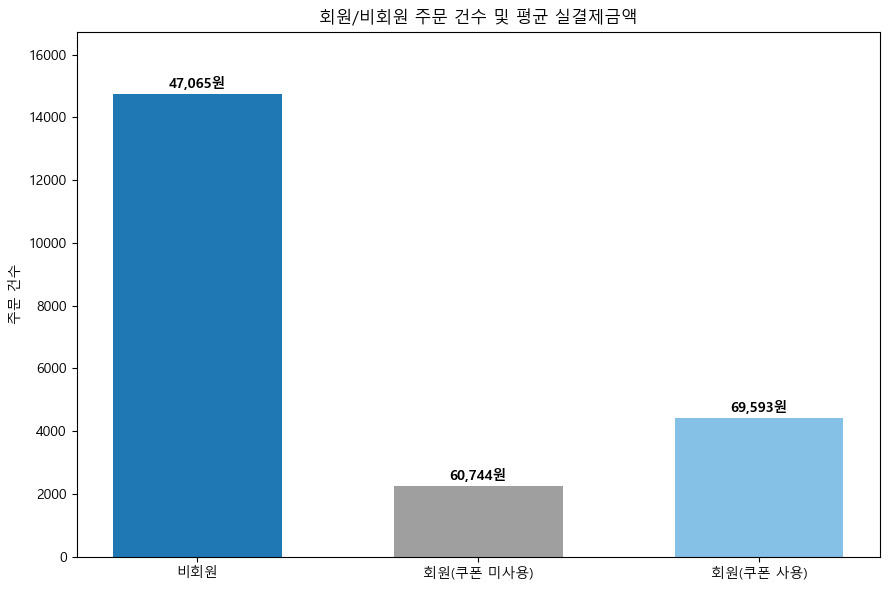

In [11]:
# 회원/비회원별 주문 건수 (중복 허용)
order_count_by_membership = order.groupby('회원여부')['주문번호'].count()

# 회원/비회원별 쿠폰 사용률
# 쿠폰 사용 여부를 나타내는 새로운 컬럼을 생성 (쿠폰 사용시 1, 사용 안했으면 0)
order['쿠폰사용여부'] = order['사용한 쿠폰명'].notna().astype(int)

# 회원/비회원별 쿠폰 사용률 계산
coupon_usage_rate_by_membership = order.groupby('회원여부')['쿠폰사용여부'].mean() * 100  # 백분율로 계산

# 결과 출력
print("회원/비회원별 주문 건수 (중복 허용):")
print(order_count_by_membership)
print("\n회원/비회원별 쿠폰 사용률 (%):")
print(coupon_usage_rate_by_membership)


# 회원/비회원별 평균 실결제금액
avg_payment_by_membership = order.groupby('회원여부')['총 실결제금액(최초정보) (KRW)'].mean()

# 결과 출력
print("회원/비회원별 주문 건수 (중복 허용):")
print(order_count_by_membership)

print("\n회원/비회원별 쿠폰 사용률 (%):")
print(coupon_usage_rate_by_membership)

print("\n회원/비회원별 평균 실결제금액:")
print(avg_payment_by_membership)


# 회원/비회원 및 쿠폰 사용 여부 기준으로 새로운 그룹 생성
order['회원_쿠폰_그룹'] = order.apply(
    lambda row: (
        '회원(쿠폰 사용)' if row['회원여부'] == '회원' and row['쿠폰사용여부'] == 1 else
        '회원(쿠폰 미사용)' if row['회원여부'] == '회원' else
        '비회원'
    ),
    axis=1
)

# 그룹별 주문 건수
order_count_by_group = order.groupby('회원_쿠폰_그룹')['주문번호'].count()

# 그룹별 평균 실결제금액
avg_payment_by_group = order.groupby('회원_쿠폰_그룹')['총 실결제금액(최초정보) (KRW)'].mean()


# 시각화
plt.figure(figsize=(9, 6))
bar_positions = np.arange(len(order_count_by_group))
bar_width = 0.6

# 색상 설정
color_map = {
    '비회원': '#1f77b4',
    '회원(쿠폰 사용)': '#85c0e7',
    '회원(쿠폰 미사용)': '#9f9f9f',
}

# 막대 그래프
bars = plt.bar(
    bar_positions,
    order_count_by_group.values,
    color=[color_map[label] for label in order_count_by_group.index],
    width=bar_width
)

# 평균 실결제금액 수치 표기
for i, bar in enumerate(bars):
    height = bar.get_height()
    group_name = order_count_by_group.index[i]
    avg_payment = avg_payment_by_group[group_name]
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 100,
        f"{avg_payment:,.0f}원",  # 천 단위 콤마 포함
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# 레이아웃 설정
plt.xticks(bar_positions, order_count_by_group.index)
plt.title('회원/비회원 주문 건수 및 평균 실결제금액')
plt.xlabel('')
plt.ylabel('주문 건수')
plt.ylim(0, order_count_by_group.max() + 2000)
plt.tight_layout()
plt.show()

## 2. 온라인 광고 효율 및 유입, 이탈 분석

### 1) GA 유입 - 트래픽 전환

In [12]:
GA = pd.read_csv('GA_202403_202502.csv')
GA

# 신규 컬럼 추가
GA['이탈율(%)'] = GA.apply(
    lambda row: 0 if row['세선 수(트래픽)'] == 0 
    else 100 - (row['참여 세션 수(트래픽)'] / row['세선 수(트래픽)'] * 100), axis=1)
GA['결제클릭전환율(%)'] = GA.apply(
    lambda row: 0 if row['세선 수(트래픽)'] == 0 else row['이벤트 수(결제하기_클릭)'] / row['세선 수(트래픽)'] * 100, axis=1)
GA['결제완료전환율(%)'] = GA.apply(
    lambda row: 0 if row['세선 수(트래픽)'] == 0 else row['이벤트 수(결제_완료)'] / row['세선 수(트래픽)'] * 100, axis=1)

GA['이탈율(%)'] = GA['이탈율(%)'].round(2)
GA['결제클릭전환율(%)'] = GA['결제클릭전환율(%)'].round(2)
GA['결제완료전환율(%)'] = GA['결제완료전환율(%)'].round(2)

print(GA)


# 시각화
fig, ax1 = plt.subplots(figsize=(10,6))

# 막대그래프: 전환율
GA.plot(x='채널 그룹', y=['결제클릭전환율(%)', '결제완료전환율(%)'], kind='bar', ax=ax1)
ax1.set_ylabel('전환율 (%)')
ax1.set_title('채널 그룹별 전환 지표 비교')
ax1.grid(True)  # 주격자선 켜기
plt.xticks(rotation=0)  

# 선그래프: 이탈율 (보조축)
ax2 = ax1.twinx()
ax2.plot(GA['채널 그룹'], GA['이탈율(%)'], color='red', marker='o', linestyle='--', label='이탈율(%)')
ax2.set_ylabel('이탈율 (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(False)  # 보조축 격자선 제거
plt.xticks(rotation=15) 

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'GA_202403_202502.csv'

### 2) Meta 캠페인 효율

🛒 웹사이트 구매 캠페인 기준 퍼널
총 노출 수: 9,896,404
총 클릭 수: 280,577
총 구매 수: 10,200

CTR (노출 → 클릭): 2.84%
클릭 대비 구매 전환률: 3.64%
노출 대비 구매 전환률: 0.1031%


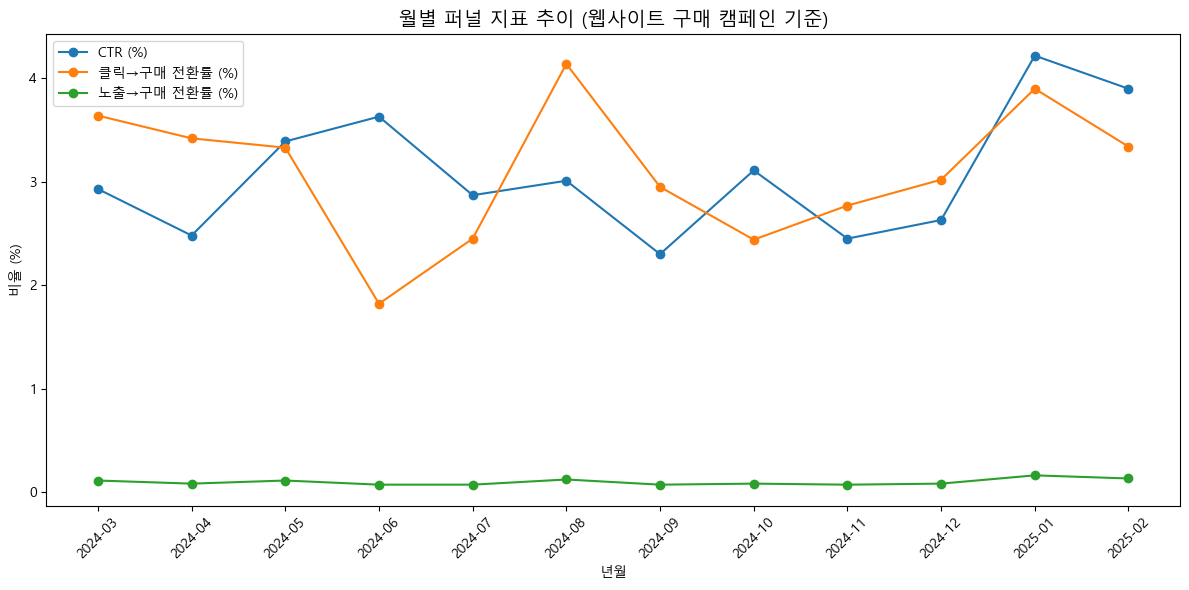

In [13]:
# 태블로 시각화용 meta_ad 재추출
meta_ad = pd.read_csv('meta_ad_final3.csv', encoding='cp949')

# 데이터 불러오기
meta_ad.columns = meta_ad.columns.str.strip()
meta_ad['광고 시작일'] = pd.to_datetime(meta_ad['광고 시작일'], format='%Y-%m-%d')
meta_ad['년월'] = meta_ad['광고 시작일'].dt.to_period('M')

# 날짜 필터링 범위 설정
start_date = '2024-03-01'
end_date = '2025-03-31'

# 필터링된 복사본 생성 (경고 방지용)
filtered_ad = meta_ad[
    (meta_ad['광고 시작일'] >= start_date) & 
    (meta_ad['광고 시작일'] <= end_date)
].copy()

# 웹사이트 구매 필터링
purchase_df = filtered_ad[filtered_ad['결과 유형'] == '웹사이트 구매'].copy()

# 숫자 컬럼 처리
for col in ['노출', '링크 클릭', '결과', '지출 금액 (KRW)']:
    purchase_df[col] = purchase_df[col].astype(str).str.replace(',', '').astype(float)

# 월별 집계 및 지표 계산
monthly_summary = purchase_df.groupby('년월').agg(
    총_노출=('노출', 'sum'),
    총_클릭=('링크 클릭', 'sum'),
    총_구매=('결과', 'sum')
).reset_index()

monthly_summary['CTR (%)'] = (monthly_summary['총_클릭'] / monthly_summary['총_노출']) * 100
monthly_summary['클릭→구매 전환률 (%)'] = (monthly_summary['총_구매'] / monthly_summary['총_클릭']) * 100
monthly_summary['노출→구매 전환률 (%)'] = (monthly_summary['총_구매'] / monthly_summary['총_노출']) * 100
monthly_summary = monthly_summary.round(2)

monthly_summary.to_csv('monthly_summary.csv', index=False, encoding='utf-8-sig')


meta_ad.columns = meta_ad.columns.str.strip()

# 금액 및 숫자 관련 컬럼 정리
meta_ad['지출 금액 (KRW)'] = meta_ad['지출 금액 (KRW)'].astype(str).str.replace(',', '').astype(float)
meta_ad['결과'] = pd.to_numeric(meta_ad['결과'], errors='coerce')
meta_ad['결과당 비용'] = meta_ad['결과당 비용'].astype(str).str.replace(',', '').astype(float)
meta_ad['노출'] = pd.to_numeric(meta_ad['노출'], errors='coerce')
meta_ad['도달'] = pd.to_numeric(meta_ad['도달'], errors='coerce')
meta_ad['CPM'] = pd.to_numeric(meta_ad['CPM'], errors='coerce')
meta_ad['링크 클릭'] = pd.to_numeric(meta_ad['링크 클릭'], errors='coerce')
meta_ad['CPC'] = pd.to_numeric(meta_ad['CPC'], errors='coerce')
meta_ad['CTR'] = pd.to_numeric(meta_ad['CTR'], errors='coerce')
meta_ad['조회'] = pd.to_numeric(meta_ad['조회'], errors='coerce')
meta_ad['빈도'] = pd.to_numeric(meta_ad['빈도'], errors='coerce')

# 컬럼 이름 공백 제거
meta_ad.columns = meta_ad.columns.str.strip()

# '결과 유형' 컬럼에서 'actions'가 포함된 행 삭제
# meta_ad = meta_ad[~meta_ad['결과 유형'].str.contains('actions', case=False, na=False)]


# 웹사이트 구매를 목표로 한 광고만 필터링
purchase_ads = meta_ad[meta_ad['결과 유형'] == '웹사이트 구매']

# 퍼널 단계별 집계
total_impressions = purchase_ads['노출'].sum()
total_clicks = purchase_ads['링크 클릭'].sum()
total_purchases = purchase_ads['결과'].sum() 

# 전환률 계산
click_through_rate = total_clicks / total_impressions * 100
purchase_rate_from_click = total_purchases / total_clicks * 100
purchase_rate_from_impression = total_purchases / total_impressions * 100

# 출력
print(f"🛒 웹사이트 구매 캠페인 기준 퍼널")
print(f"총 노출 수: {total_impressions:,.0f}")
print(f"총 클릭 수: {total_clicks:,.0f}")
print(f"총 구매 수: {total_purchases:,.0f}")
print(f"\nCTR (노출 → 클릭): {click_through_rate:.2f}%")
print(f"클릭 대비 구매 전환률: {purchase_rate_from_click:.2f}%")
print(f"노출 대비 구매 전환률: {purchase_rate_from_impression:.4f}%")


# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows에서 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 제대로 표시되도록 설정

# 데이터 불러오기
meta_ad.columns = meta_ad.columns.str.strip()
meta_ad['광고 시작일'] = pd.to_datetime(meta_ad['광고 시작일'], format='%Y-%m-%d')
meta_ad['년월'] = meta_ad['광고 시작일'].dt.to_period('M')

# 날짜 필터링 범위 설정
start_date = '2024-03-01'
end_date = '2025-03-31'

# 필터링된 복사본 생성 (경고 방지용)
filtered_ad = meta_ad[
    (meta_ad['광고 시작일'] >= start_date) & 
    (meta_ad['광고 시작일'] <= end_date)
].copy()

# 웹사이트 구매 필터링
purchase_df = filtered_ad[filtered_ad['결과 유형'] == '웹사이트 구매'].copy()

# 숫자 컬럼 처리
for col in ['노출', '링크 클릭', '결과', '지출 금액 (KRW)']:
    purchase_df[col] = purchase_df[col].astype(str).str.replace(',', '').astype(float)

# 월별 집계 및 지표 계산
monthly_summary = purchase_df.groupby('년월').agg(
    총_노출=('노출', 'sum'),
    총_클릭=('링크 클릭', 'sum'),
    총_구매=('결과', 'sum')
).reset_index()

monthly_summary['CTR (%)'] = (monthly_summary['총_클릭'] / monthly_summary['총_노출']) * 100
monthly_summary['클릭→구매 전환률 (%)'] = (monthly_summary['총_구매'] / monthly_summary['총_클릭']) * 100
monthly_summary['노출→구매 전환률 (%)'] = (monthly_summary['총_구매'] / monthly_summary['총_노출']) * 100
monthly_summary = monthly_summary.round(2)

# 시각화
plt.figure(figsize=(12, 6))

# 선 그래프 3개 그리기
plt.plot(monthly_summary['년월'].astype(str), monthly_summary['CTR (%)'], marker='o', label='CTR (%)')
plt.plot(monthly_summary['년월'].astype(str), monthly_summary['클릭→구매 전환률 (%)'], marker='o', label='클릭→구매 전환률 (%)')
plt.plot(monthly_summary['년월'].astype(str), monthly_summary['노출→구매 전환률 (%)'], marker='o', label='노출→구매 전환률 (%)')

# 그래프 꾸미기
plt.title('월별 퍼널 지표 추이 (웹사이트 구매 캠페인 기준)', fontsize=14)
plt.xlabel('년월')
plt.ylabel('비율 (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 3) 베스트제품

In [14]:
# 데이터 불러오기
df = pd.read_csv('order_cleaned.csv', encoding='utf-8')

# 숫자형 변환
df['상품구매금액'] = pd.to_numeric(df['상품구매금액'], errors='coerce')

# 🔹 제품별 판매건수 및 총 매출 집계
product_summary = df.groupby('주문상품명').agg(
    판매건수=('주문번호', 'count'),
    총매출=('상품구매금액', 'sum')
).reset_index()

# 🔹 판매건수 기준 TOP 5
top_5_by_orders = product_summary.sort_values(by='판매건수', ascending=False).head(5)

# 🔹 매출 기준 TOP 5
top_5_by_sales = product_summary.sort_values(by='총매출', ascending=False).head(5)

# 결과 출력
print("📦 판매건수 기준 TOP 5 제품:")
print(top_5_by_orders)

print("\n💰 총매출 기준 TOP 5 제품:")
print(top_5_by_sales)

📦 판매건수 기준 TOP 5 제품:
                 주문상품명  판매건수        총매출
138         호안오닉스 카네스톤  5445  217856000
84        자마노 레브스톤 4mm  2085   83672000
139         호안오닉스 팬텀골드  1338   61144000
122       호안석 골드 플렌티스톤   943   42226000
17   레브스톤 포르테스톤 세트 4mm   743   36908500

💰 총매출 기준 TOP 5 제품:
            주문상품명  판매건수        총매출
138    호안오닉스 카네스톤  5445  217856000
84   자마노 레브스톤 4mm  2085   83672000
139    호안오닉스 팬텀골드  1338   61144000
105     팬텀골드 커플세트   562   44057000
122  호안석 골드 플렌티스톤   943   42226000


## 4. 정석적, 정량적 리뷰 분석

### 1) 부정 리뷰

In [15]:
df = pd.read_csv("review_cleaned.csv")

# 모델 불러오기
model_id = "sangrimlee/bert-base-multilingual-cased-nsmc"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

# 감성 분류 함수 정의
def classify_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    label = torch.argmax(probs).item()
    return "부정" if label == 0 else "긍정"

# 리뷰에 적용
df['감성'] = df['리뷰내용'].apply(classify_sentiment)

# 텍스트 전처리 (불용어 제거)
stopwords = [
    "정말", "진짜", "너무", "그리고", "그래서", "하면", "하는", "해서", "부터", "까지", "ㅎ", "ㅎㅎ", "ㅎㅎㅎ", "^^", "제가", "!", "!!", "...", "~!",
    "이런", "저런", "그런", "요즘", "거의", "그냥", "조금", "많이", "많은", "같은", "가볍게", "가능한", "샀는데", "구매", "~", "~~", "~~~",
    "하지만", "또한", "때문에", "그래도", "이다", "입니다", "있습니다", "합니다", "했어요", "못했어요", "했는데", "구매하고", "ㅠㅠ", "ㅜㅜ", "ㅠㅠㅠ",
    "감사합니다", "배송", "포장", "구매", "주문", "상품", "했습니다", "만큼", "싶어요", "다음에도", "훨씬", "있어서", "다른", "^^♡", "^^ㅋ", "ㅋㅋㅋ",
    "가격", "빠르고", "빠름", "잘", "사용", "리뷰", "도착", "괜찮아요", "괜찮고", "생각보다", "때문", "모두", "바로", "팔찌", "♡", "♡♡", "ㅋㅋ",
    "좋고", "이거", "저거", "거", "것", "좀", "듯", "더", "아주", "또", "와서", "그", "제품이에요", "살짝", "매일", "리코맨즈", "^ ^", "^^&",
    "상품이에요??", "감사합니다", "감사합니다.", "주문했는데", "같아요", "구매했어요", "구매했습니다", "상품이에요",
    "고민", "중", "보고", "보고서", "보니", "보니까", "정도", "이제", "항상", "마음에", "맘에", "분들에게도", "싶어요!!", "싶어요.??", "싶어요. ??", "♥",
    "싶어요.", "제품이에요.", "구매했습니다.", "구매했어요!", "사용할", "같아요!", "같아", "????", "??", "제품이예요~!", "제품이예요.", "cm"
]


# 리뷰 주제 분류 함수 정의
def classify_topic(text):
    text = str(text).lower()

    # 내구성 관련
    durability_keywords = ['터짐', '줄이 얇', '허술', '고무줄', '줄이', '끈이', '약해', '약하', '망가', '끊어', '끈어', '터져',
                           '낚시줄', '늘어난', '줄', '자꾸 떨어져', '쉽게 떨어', '너무잘풀림', '자석이 너무 헐거워', '자석이 너무 쉽게']
    if any(kw in text for kw in durability_keywords):
        return '내구성'

    # 사이즈 관련
    size_keywords = ['사이즈 작', '작다', '작음', '크다', '길이', '짧', '사이즈 미스', '사이즈가', '사이즈다안맏네', '작네요', '작구요',
                     '알이', '꽉껴', '작아', '작고', '크네', '길이', '쪼입', '사이즈 불만', '좀 더 컸으면', '자석이 하루만에 이탈되어']
    if any(kw in text for kw in size_keywords):
        return '사이즈'

    # 실물과 사진이 다름
    mismatch_keywords = ['사진이랑 다', '광고랑 다', '실물', '이미지랑', '별로', '저렴해 보', '기대이하', '빠진것처럼'
                         '화면에서', '사진보다 너무', '색이 많이 어두워', '하나빠진거같은데요?', '사진이랑 좀 다른']
    if any(kw in text for kw in mismatch_keywords):
        return '사진 불일치'

    # 재질/디자인 실망
    design_keywords = ['디자인 실망', '조잡', '싸구려', '플라스틱 같', '색감 별로', '고급스럽지 않', '싼티', '벌써 벗겨'
                       '장난감', '너무 두꺼워', '보기가 싫', '가짜', '벗겨', '탈색', '촌티', '촌스럽', '고급스러움이랑은 거리가 멀고']
    if any(kw in text for kw in design_keywords):
        return '재질/디자인'

    # 착용감 불편
    wear_keywords = ['불편', '답답', '거슬림', '착용감', '딱딱', '쪼입', '꽉껴', '타이트']
    if any(kw in text for kw in wear_keywords):
        return '착용감'

    # 배송/포장 문제
    delivery_keywords = ['배송', '포장', '지연', '찢어짐', '파손', '뜯어진', '느리고', '기스', '깨져서']
    if any(kw in text for kw in delivery_keywords):
        return '배송/포장 문제'

    # 전반적 불만족 문제
    delivery_keywords = ['만족하지는 못', '아쉽', '좋지않아요', '부족한 느낌', '실망입니다', '그럭저럭', '두배 가격',
                         '비싸요', '아쉬움', '넘 기대를 많이 했나봐요~']
    if any(kw in text for kw in delivery_keywords):
        return '전반적 불만족'
    
    return '기타'

# 부정 리뷰 필터링 후 리뷰주제 컬럼 생성
negative_df = df[df['감성'] == '부정'].copy()
negative_df['리뷰주제'] = negative_df['리뷰내용'].apply(classify_topic)

# 주제별 부정 리뷰 수 확인
topic_counts = negative_df['리뷰주제'].value_counts().reset_index()
topic_counts.columns = ['리뷰주제', '리뷰 수']
topic_counts


# 기타 리뷰 내용 확인 >> 확인 결과 긍정리뷰 내용 (172건)

# '리뷰주제'가 '기타'인 리뷰 내용만 추출
etc_reviews = negative_df[negative_df['리뷰주제'] == '기타']['리뷰내용']

for review in etc_reviews:
    print("-", review)


# 기타항목 제외 버블차트 레이블 제거 버전

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 준비
topic_counts_filtered = topic_counts[topic_counts['리뷰주제'] != '기타'].copy()
total = topic_counts_filtered['리뷰 수'].sum()
topic_counts_filtered['비중 (%)'] = topic_counts_filtered['리뷰 수'] / total * 100

labels = topic_counts_filtered['리뷰주제'].tolist()
values = topic_counts_filtered['비중 (%)'].tolist()
n = len(labels)

# 2. 버블 크기 조정
min_radius = 40    # 가장 작은 버블의 반지름
max_radius = 120   # 가장 큰 버블의 반지름
max_val = max(values)
radii = [min_radius + (v / max_val) * (max_radius - min_radius) for v in values]
sizes = [r**2 * np.pi for r in radii]  # 면적 기반으로 변경

# 3. 버블 위치 수동 지정 (n 개수에 맞춰 직접 조절 필요)
positions = [
    ( 0.10,  0.40),   # 전반적 불만족
    (-0.15, -0.45),   # 내구성
    (-0.50,  0.30),   # 사이즈
    ( 0.30, -0.28),   # 배송/포장 문제
    ( 0.55, 0.00),    # 사진 불일치
    (-0.58, -0.19),   # 재질/디자인
    ( 0.60, -0.40),   # 착용감
]
x = [pos[0] for pos in positions]
y = [pos[1] for pos in positions]

# 4. 색상 설정
highlight_labels = ['내구성', '사이즈', '배송/포장 문제', '사진 불일치']
colors_used = []

for label in labels:
    if label in highlight_labels:
        colors_used.append('#4E4138')  # 진한색
    else:
        colors_used.append('#F4EFE9')  # 밝은색

# 5. 시각화
plt.figure(figsize=(10, 8))
plt.axis('off')
for i in range(n):
    plt.scatter(x[i], y[i], s=sizes[i], color=colors_used[i], alpha=0.9)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.tight_layout()
plt.savefig("review_topic_bubble_non-label.png", dpi=300, transparent=True)
plt.show()

tokenizer_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

C:\Users\user\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--sangrimlee--bert-base-multilingual-cased-nsmc. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

KeyboardInterrupt: 